In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn import mixture
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import itertools
from scipy import linalg
import matplotlib as mpl

In [3]:
digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = (digits.target).reshape(1797,1)
print(labels.shape)
print(data.shape)

(1797, 1)
(1797, 64)


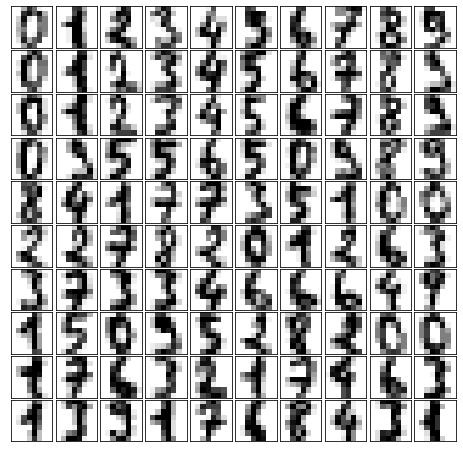

In [4]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

([], <a list of 0 Text yticklabel objects>)

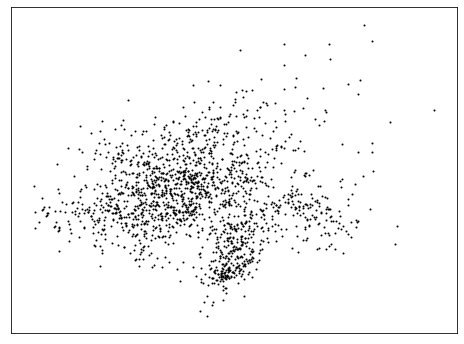

In [5]:
reduced_data = PCA(n_components=2).fit_transform(data)

plt.figure(figsize=(8, 6))
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

In [27]:
from matplotlib.patches import Ellipse
colors = ['navy', 'turquoise', 'darkorange','red', 'plum', 'slategray'] # will need to add other colours here if more clusters
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

BIC SCORE

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=4, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)


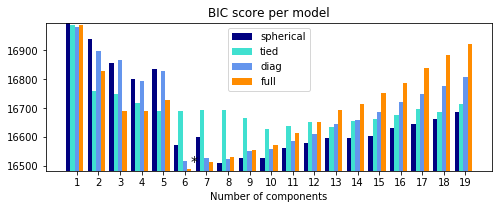

In [26]:
bic = []
lowest_bic = np.infty
n_components_range = range(1, 20)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type, random_state=4)
        gmm.fit(reduced_data)
        bic.append(gmm.bic(reduced_data))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf1 = best_gmm
print(clf1)
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

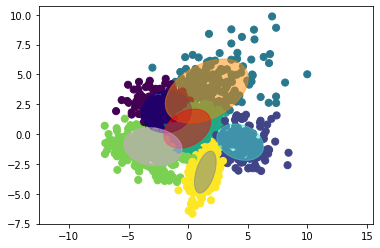

In [28]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clf1.predict(reduced_data), s=50, cmap='viridis')
make_ellipses(clf1, plt.gca())

AIC SCORE

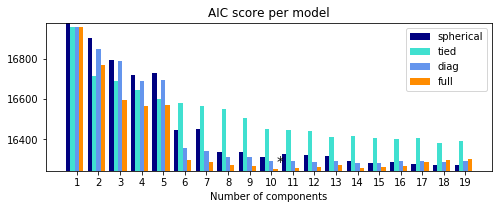

In [9]:
aic = []
lowest_aic=np.infty
n_components_range = range(1, 20)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type, random_state=4)
        gmm.fit(reduced_data)
        aic.append(gmm.aic(reduced_data))
        if aic[-1] < lowest_aic:
            lowest_aic = aic[-1]
            best_gmm = gmm

aic = np.array(aic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf2 = best_gmm
bars = []

# Plot the AIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, aic[i * len(n_components_range):(i + 1) * len(n_components_range)],width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([aic.min() * 1.01 - .01 * aic.max(), aic.max()])
plt.title('AIC score per model')
xpos = np.mod(aic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(aic.argmin() / len(n_components_range))
plt.text(xpos, aic.min() * 0.97 + .03 * aic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

In [29]:
from matplotlib.patches import Ellipse
colors = ['navy', 'turquoise', 'darkorange','red', 'plum', 'slategray', 'tan','pink','aqua','yellow'] # will need to add other colours here if more clusters
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

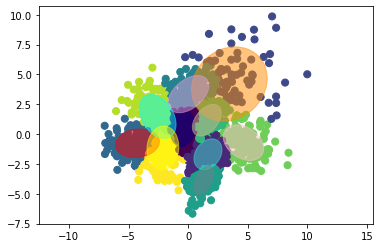

In [30]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clf2.predict(reduced_data), s=50, cmap='viridis')
make_ellipses(clf2, plt.gca())

SILHOUETTE SCORE

Max Score  0.38435557781334384


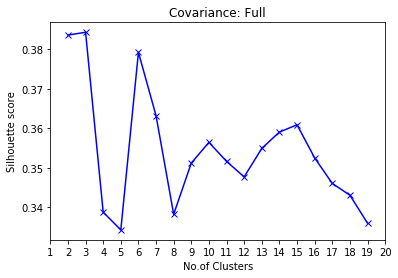

In [11]:
clusters = range(2,20)
score=[]
score1 =[]
for k in clusters:
    clf3 = mixture.GaussianMixture(n_components = k,covariance_type='full', random_state=4)
    clf3.fit(reduced_data)
    y_predict = clf3.predict(reduced_data)
    score = silhouette_score(reduced_data, y_predict, metric='euclidean')
    score1.append(score)

print("Max Score ", max(score1))
plt.plot(clusters,score1, 'bx-') 
plt.xticks(np.arange(1, 21, 1.0))
plt.xlabel('No.of Clusters') 
plt.ylabel('Silhouette score') 
plt.title('Covariance: Full') 
plt.show()

Max Score  0.39400640708428925


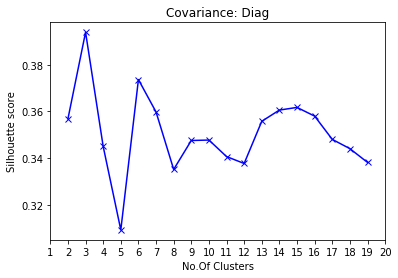

In [31]:
clusters = range(2,20)
score=[]
score1 =[]
for k in clusters:
    clf4 = mixture.GaussianMixture(n_components = k,covariance_type='diag', random_state=4)
    clf4.fit(reduced_data)
    y_predict = clf4.predict(reduced_data)
    score = silhouette_score(reduced_data, y_predict, metric='euclidean')
    score1.append(score)

print("Max Score ", max(score1))
plt.plot(clusters,score1, 'bx-') 
plt.xticks(np.arange(1, 21, 1.0))
plt.xlabel('No.Of Clusters') 
plt.ylabel('Silhouette score') 
plt.title('Covariance: Diag') 
plt.show()

Max Score  0.396016523016393


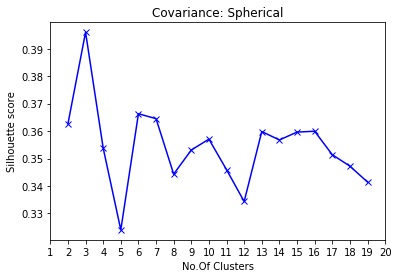

In [32]:
clusters = range(2,20)
score=[]
score1 =[]
for k in clusters:
    clf5 = mixture.GaussianMixture(n_components = k,covariance_type='spherical', random_state=4)
    clf5.fit(reduced_data)
    y_predict = clf5.predict(reduced_data)
    score = silhouette_score(reduced_data, y_predict, metric='euclidean')
    score1.append(score)
   
print("Max Score ", max(score1))
plt.plot(clusters,score1, 'bx-') 
plt.xlabel('No.Of Clusters') 
plt.xticks(np.arange(1, 21, 1.0))
plt.ylabel('Silhouette score') 
plt.title('Covariance: Spherical') 
plt.show()

Max Score  0.38523071068140846


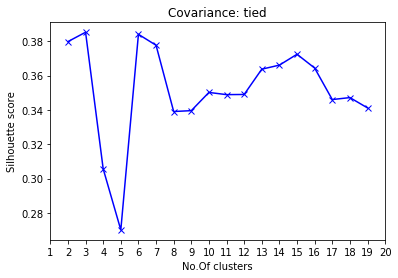

In [33]:
clusters = range(2,20)
score=[]
score1 =[]
for k in clusters:
    clf6 = mixture.GaussianMixture(n_components = k,covariance_type='tied', random_state=4)
    clf6.fit(reduced_data)
    y_predict = clf6.predict(reduced_data)
    score = silhouette_score(reduced_data, y_predict, metric='euclidean')
    score1.append(score)

print("Max Score ", max(score1))
plt.plot(clusters,score1, 'bx-') 
plt.xticks(np.arange(1, 21, 1.0))
plt.xlabel('No.Of clusters') 
plt.ylabel('Silhouette score') 
plt.title('Covariance: tied') 
plt.show()

In [42]:
from matplotlib.patches import Ellipse
colors = ['navy', 'turquoise', 'darkorange','red', 'plum'] # will need to add other colours here if more clusters
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

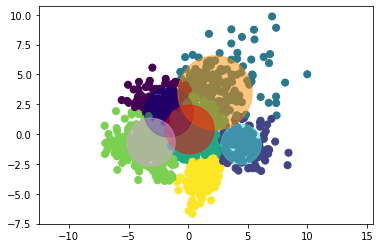

In [44]:
clf5 = mixture.GaussianMixture(n_components = 6,covariance_type='spherical', random_state=4)
clf5.fit(reduced_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clf5.predict(reduced_data), s=50, cmap='viridis')
make_ellipses(clf5, plt.gca())

CROSS VALIDATION

Max Score  -4.5009423976058


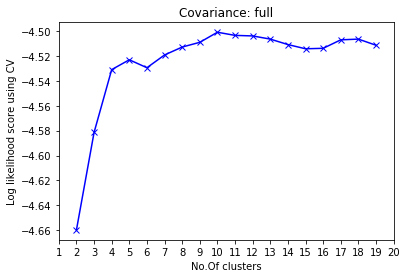

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(reduced_data, test_size=0.33, random_state=42)

score =[]
for k in clusters:
    clf7 = mixture.GaussianMixture(n_components = k,covariance_type='full', random_state=4)
    clf7.fit(X_train)
    score.append(clf7.score(X_test))

print("Max Score ", max(score))
plt.plot(clusters,score, 'bx-') 
plt.xticks(np.arange(1, 21, 1.0))
plt.xlabel('No.Of clusters') 
plt.ylabel('Log likelihood score using CV') 
plt.title('Covariance: full') 
plt.show()

Max Score  -4.5005647119038965


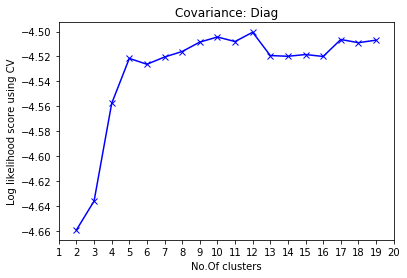

In [36]:
score =[]
for k in clusters:
    clf8 = mixture.GaussianMixture(n_components = k,covariance_type='diag', random_state=4)
    clf8.fit(X_train)
    score.append(clf8.score(X_test))

print("Max Score ", max(score))
plt.plot(clusters,score, 'bx-') 
plt.xticks(np.arange(1, 21, 1.0))
plt.xlabel('No.Of clusters') 
plt.ylabel('Log likelihood score using CV') 
plt.title('Covariance: Diag') 
plt.show()

Max Score  -4.511415356618335


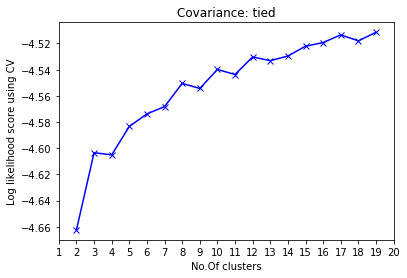

In [37]:
score =[]
for k in clusters:
    clf9 = mixture.GaussianMixture(n_components = k,covariance_type='tied', random_state=4)
    clf9.fit(X_train)
    score.append(clf9.score(X_test))

print("Max Score ", max(score))
plt.plot(clusters,score, 'bx-') 
plt.xticks(np.arange(1, 21, 1.0))
plt.xlabel('No.Of clusters') 
plt.ylabel('Log likelihood score using CV') 
plt.title('Covariance: tied') 
plt.show()

Max Score  -4.495743184501109


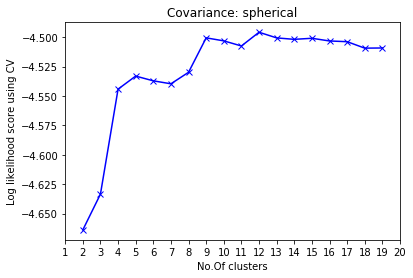

In [38]:
score =[]
for k in clusters:
    clf10 = mixture.GaussianMixture(n_components = k,covariance_type='spherical', random_state=4)
    clf10.fit(X_train)
    score.append(clf10.score(X_test))

print("Max Score ", max(score))
plt.plot(clusters,score, 'bx-') 
plt.xticks(np.arange(1, 21, 1.0))
plt.xlabel('No.Of clusters') 
plt.ylabel('Log likelihood score using CV') 
plt.title('Covariance: spherical') 
plt.show()

In [47]:
from matplotlib.patches import Ellipse
colors = ['navy', 'turquoise', 'darkorange','red', 'plum','slategray', 'tan','pink','aqua','yellow','blue','green'] # will need to add other colours here if more clusters
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

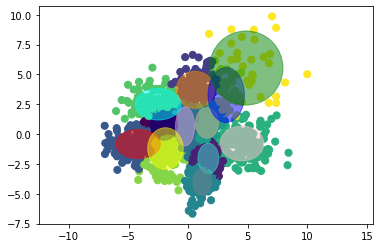

In [48]:
clf11 = mixture.GaussianMixture(n_components = 12,covariance_type='diag', random_state=4)
clf11.fit(reduced_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clf11.predict(reduced_data), s=50, cmap='viridis')
make_ellipses(clf11, plt.gca())